In [57]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
spark = SparkSession.builder.appName('2021EDA').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.stage.maxConsecutiveAttempts', '10'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.submit.pyFiles',
  '/root/.ivy2/jars/com.johnsnowlabs.nlp_spark-nlp_2.12-4.4.0.jar,/root/.ivy2/jars/graphframes_graphframes-0.8.2-spark3.1-s_2.12.jar,/root/.ivy2/jars/com.typesafe_config-1.4.2.jar,/root/.ivy2/jars/org.rocksdb_rocksdbjni-6.29.5.jar,/root/.ivy2/jars/com.amazonaws_aws-java-sdk-bundle-1.11.828.jar,/root/.ivy2/jars/com.github.universal-automata_liblevenshtein-3.0.0.jar,/root/.ivy2/jars/com.google.cloud_google-cloud-storage-2.16.0.jar,/root/.ivy2/jars/com.navigamez_greex-1.0.jar,/root/.ivy2/jars/com.johnsnowlabs.nlp_tensorflow-cpu_2.12-0.4.4.jar,/root/.ivy2/jars/it.unimi.dsi_fastutil-7.0.12.jar,/root/.ivy2/jars/org.projectlombok_lombok-1.16.8.jar,/root/.ivy2/jars/com.google.guava_guava-31.1-jre.jar,/root/.ivy2/jars/com.google.guava_failureaccess-1.0.1.jar,/root/.ivy2/jars/com.google.guava_listenablefuture-9999.0-empty-to-avoid-conflict-

In [88]:
df_2021 = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/2022", inferSchema=True, header=True)
# figure out how to read in shp file msca-bdp-student-gcs/bdp-rideshare-project/neighborhoods/shp files
df_weather = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/weather/chicago 2020-01-01 to 2022-08-31.csv", inferSchema=True, header=True)
df_2021.printSchema()
df_weather.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tip: integer (nullable = true)
 |-- Additional Charges: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Shared Trip Authorized: boolean (nullable = true)
 |-- Trips Pooled: integer (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid Longitude: double (nullable = true)
 |-- Dropof

In [89]:
#display number of records by partition
def displaypartitions(df):
    #number of records by partition
    num = df.rdd.getNumPartitions()
    print("Partitions:", num)
    df.withColumn("partitionId", F.spark_partition_id())\
        .groupBy("partitionId")\
        .count()\
        .orderBy(F.asc("count"))\
        .show(num)

df_2021.rdd.getNumPartitions()

135

In [90]:
displaypartitions(df_2021)

Partitions: 135


+-----------+------+
|partitionId| count|
+-----------+------+
|        134|337327|
|         22|499083|
|        123|504285|
|        126|504809|
|        115|504841|
|         95|505099|
|         87|505483|
|         10|505553|
|        129|505717|
|        109|505821|
|         30|506415|
|         12|506815|
|        112|506840|
|        118|506913|
|          8|507499|
|         17|507526|
|         40|507585|
|         53|507693|
|         90|507836|
|         27|507856|
|         71|508094|
|        100|508435|
|        103|508829|
|         74|508860|
|         92|509111|
|        106|509156|
|         50|509316|
|         45|509490|
|         25|509572|
|         79|509585|
|         48|509604|
|         89|509853|
|         32|510003|
|         66|510055|
|         58|510094|
|         82|510167|
|         37|510177|
|         61|510194|
|          6|510259|
|         35|510618|
|         19|510748|
|          4|510798|
|         68|510849|
|         77|510867|
|         97|

In [67]:
# df_2021 = df_2021.repartition(10)

In [68]:
displaypartitions(df_2021)

Partitions: 10


+-----------+------+
|partitionId| count|
+-----------+------+
|          5|270864|
|          7|270865|
|          6|270865|
|          0|270865|
|          9|270866|
|          1|270866|
|          4|270866|
|          8|270866|
|          2|270866|
|          3|270867|
+-----------+------+



In [8]:
df_2021.describe().show()

+-------+----------------+--------------------+--------------------+-----------------+-----------------+--------------------+--------------------+---------------------+----------------------+------------------+------------------+------------------+------------------+--------------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+-------------------------+
|summary|         Trip ID|Trip Start Timestamp|  Trip End Timestamp|     Trip Seconds|       Trip Miles| Pickup Census Tract|Dropoff Census Tract|Pickup Community Area|Dropoff Community Area|              Fare|               Tip|Additional Charges|        Trip Total|        Trips Pooled|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Centroid Location|Dropoff Centroid Latitude|Dropoff Centroid Longitude|Dropoff Centroid Location|
+-------+----------------+--------------------+--------------------+-----------------+-----------------+--------

In [91]:
#Find the number of missing values for each column
from pyspark.sql.functions import isnan, when, count, col
df_2021.select([count(when(df_2021[c].isNull(), c)).alias(c) for c in df_2021.columns]).show()

+-------+--------------------+------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+------+------+------------------+----------+----------------------+------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+-------------------------+
|Trip ID|Trip Start Timestamp|Trip End Timestamp|Trip Seconds|Trip Miles|Pickup Census Tract|Dropoff Census Tract|Pickup Community Area|Dropoff Community Area|  Fare|   Tip|Additional Charges|Trip Total|Shared Trip Authorized|Trips Pooled|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Centroid Location|Dropoff Centroid Latitude|Dropoff Centroid Longitude|Dropoff Centroid Location|
+-------+--------------------+------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+------+------+------------------+----------+-------

In [10]:
# number of observations with all the data in each column
df_2021.dropna(how='any').count()

921081

In [93]:
# Working with just data that contains full information and check for dupes
df_2021 = df_2021.dropna(how='any', subset=['Trip Start Timestamp','Trip End Timestamp','Fare','Dropoff Community Area','Pickup Community Area'])
df_2021 = df_2021.dropDuplicates()
# df_2021.count()

In [94]:
# Drop columns unlikely to be useful for analysis for speed of computation and rename columns to remove spacing for ease of code writing
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

df_2021 = df_2021.drop('Trips Pooled','Additional Charges','Shared Trip Authorized','Pickup Centroid Location','Dropoff Centroid Location')
df_2021 = df_2021.withColumnRenamed("Trip ID","ID").withColumnRenamed("Trip Start Timestamp","start_timestamp").withColumnRenamed("Trip End Timestamp","end_timestamp").withColumnRenamed("Trip Miles",\
                "miles").withColumnRenamed("Pickup Census Tract","pickup_tract").withColumnRenamed("Dropoff Census Tract","dropoff_tract").withColumnRenamed("Pickup Community Area","pickup_area"\
                ).withColumnRenamed("Dropoff Community Area","dropoff_area").withColumnRenamed("Trip Total","total").withColumnRenamed("Pickup Centroid Latitude","pickup_lat").withColumnRenamed(\
                "Pickup Centroid Longitude","pickup_lon").withColumnRenamed("Pickup Centroid Location","pickup_location").withColumnRenamed("Dropoff Centroid Latitude","dropoff_lat").withColumnRenamed(\
                "Dropoff Centroid Longitude","dropoff_lon").withColumnRenamed("Dropoff Centroid Location","dropoff_location")
# fix datatypes
df_2021 = df_2021.withColumn('start_timestamp', F.to_timestamp(df_2021['start_timestamp'], 'MM/dd/yyyy hh:mm:ss a')).withColumn('end_timestamp', F.to_timestamp(df_2021['end_timestamp'], 'MM/dd/yyyy hh:mm:ss a'))
df_weather = df_weather.withColumn('datetime',F.to_date(df_weather['datetime'], "yyyy-MM-dd"))


In [101]:
# add the month column
df_2021 = df_2021.withColumn('month', F.month(df_2021.start_timestamp))
df_2021 = df_2021.withColumn('hour', F.hour(df_2021.start_timestamp))

In [96]:
# get rides that occurred within hyde park
# add kenwood and woodlawn to this list - only if the other location is hyde park                    
df_hp = df_2021.filter((df_2021.pickup_area == 41) & (df_2021.dropoff_area == 41))
df_kw = df_2021.filter(((df_2021.pickup_area == 41) & (df_2021.dropoff_area == 42)) | ((df_2021.pickup_area == 42) & (df_2021.dropoff_area == 41)))
df_wl = df_2021.filter(((df_2021.pickup_area == 41) & (df_2021.dropoff_area == 39)) | ((df_2021.pickup_area == 39) & (df_2021.dropoff_area == 41)))
df_area = df_hp.union(df_kw).union(df_wl)

In [97]:
df_area.show(5)

+--------------------+-------------------+-------------------+------------+-----+------------+-------------+-----------+------------+----+---+-----------------+-------------+--------------+--------------------+-------------+--------------+--------------------+-----+
|                  ID|    start_timestamp|      end_timestamp|Trip Seconds|miles|pickup_tract|dropoff_tract|pickup_area|dropoff_area|Fare|Tip|            total|   pickup_lat|    pickup_lon|     pickup_location|  dropoff_lat|   dropoff_lon|    dropoff_location|month|
+--------------------+-------------------+-------------------+------------+-----+------------+-------------+-----------+------------+----+---+-----------------+-------------+--------------+--------------------+-------------+--------------+--------------------+-----+
|c958c47a865cd140f...|2022-01-05 13:15:00|2022-01-05 13:15:00|         311|  0.9|        null|         null|         41|          41| 7.5|  0|             8.52| 41.794090253| -87.592310855|POINT (-87

<AxesSubplot:xlabel='month'>

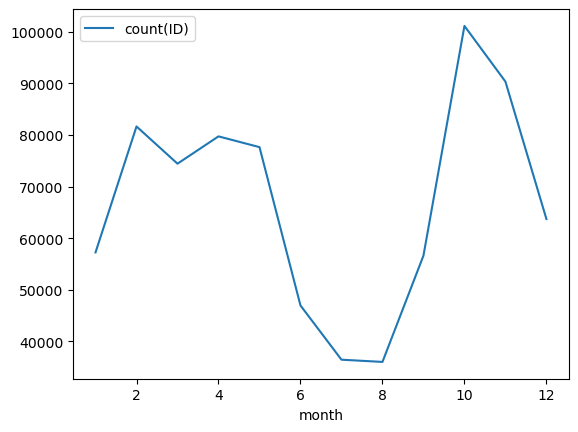

In [98]:
df_area.groupby("month").agg({'ID':'count'}).orderBy(F.col('month').asc()).toPandas().plot(x="month",y="count(ID)")

The code after this point is what remains to be done and is untested. If we all finish the things written below we should be done with the EDA

In [ ]:
# verify this is the correct time period for your given year
df_area_program = df_area.filter((df_area.Fare <= 15.0) & (df_area.hour >= 17) & (df_area.hour < 4))
# do the same kind of monthly plot here

In [99]:
from pyspark.sql.functions import approxCountDistinct

df_area.select(approxCountDistinct("ID", rsd = 0.05)).show()

+-------------------------+
|approx_count_distinct(ID)|
+-------------------------+
|                   858074|
+-------------------------+



In [79]:
# basic plots for all rides (not just in the program area)
df_2021.groupby("month").agg({'ID':'count'}).orderBy(F.col('month').asc()).toPandas().plot(x="month",y="count(ID)")

+-----+
|month|
+-----+
|    1|
+-----+



In [ ]:
df_2021.groupby("pickup_area").agg({'ID':'count'}).orderBy(F.col('pickup_area').asc()).toPandas().plot(x="pickup_area",y="count(ID)")

In [ ]:
df_2021.groupby("dropoff_area").agg({'ID':'count'}).orderBy(F.col('dropoff_area').asc()).toPandas().plot(x="pickup_area",y="count(ID)")

# Next Steps
Filter the in-area dataframe to only include rides with a fare under 15, and rides within the timeframe for the given year.

plot rides by hour


## we still don't know how to do these, if you figure it out pls share
the geospatial ipynb (notebook 4.8) from ashish shows some ways to work with this kind of data in pyspark

Plot Cloropleths (for all of chicago)

heat map of dropoff location and pickup location (for in-program rides)

for 2021 - think about how to show the september to october switch - vline when program starts

add vertical lines at and key shifts in the program policy